In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:48 - loss: 2.3137 - STD: 0.1411 - MAE: 0.2232

 16/773 [..............................] - ETA: 2s - loss: 1.4328 - STD: 0.1867 - MAE: 0.1518   

 31/773 [>.............................] - ETA: 2s - loss: 1.3813 - STD: 0.1946 - MAE: 0.1464

 47/773 [>.............................] - ETA: 2s - loss: 1.3679 - STD: 0.1924 - MAE: 0.1469

 64/773 [=>............................] - ETA: 2s - loss: 1.3549 - STD: 0.1921 - MAE: 0.1465

 81/773 [==>...........................] - ETA: 2s - loss: 1.3507 - STD: 0.1913 - MAE: 0.1467

 98/773 [==>...........................] - ETA: 2s - loss: 1.3439 - STD: 0.1914 - MAE: 0.1464

115/773 [===>..........................] - ETA: 2s - loss: 1.3394 - STD: 0.1914 - MAE: 0.1462

132/773 [====>.........................] - ETA: 2s - loss: 1.3341 - STD: 0.1913 - MAE: 0.1461

149/773 [====>.........................] - ETA: 1s - loss: 1.3275 - STD: 0.1917 - MAE: 0.1457

166/773 [=====>........................] - ETA: 1s - loss: 1.3183 - STD: 0.1923 - MAE: 0.1451

183/773 [======>.......................] - ETA: 1s - loss: 1.3093 - STD: 0.1927 - MAE: 0.1447

199/773 [======>.......................] - ETA: 1s - loss: 1.2989 - STD: 0.1932 - MAE: 0.1442

216/773 [=======>......................] - ETA: 1s - loss: 1.2868 - STD: 0.1938 - MAE: 0.1436

233/773 [========>.....................] - ETA: 1s - loss: 1.2752 - STD: 0.1945 - MAE: 0.1431

249/773 [========>.....................] - ETA: 1s - loss: 1.2646 - STD: 0.1950 - MAE: 0.1425

265/773 [=========>....................] - ETA: 1s - loss: 1.2539 - STD: 0.1957 - MAE: 0.1419

282/773 [=========>....................] - ETA: 1s - loss: 1.2418 - STD: 0.1965 - MAE: 0.1411

298/773 [==========>...................] - ETA: 1s - loss: 1.2316 - STD: 0.1972 - MAE: 0.1405

314/773 [===========>..................] - ETA: 1s - loss: 1.2224 - STD: 0.1978 - MAE: 0.1400

329/773 [===========>..................] - ETA: 1s - loss: 1.2136 - STD: 0.1984 - MAE: 0.1395

345/773 [============>.................] - ETA: 1s - loss: 1.2044 - STD: 0.1991 - MAE: 0.1389

361/773 [=============>................] - ETA: 1s - loss: 1.1950 - STD: 0.1998 - MAE: 0.1382

371/773 [=============>................] - ETA: 1s - loss: 1.1899 - STD: 0.2002 - MAE: 0.1379

387/773 [==============>...............] - ETA: 1s - loss: 1.1800 - STD: 0.2010 - MAE: 0.1372

403/773 [==============>...............] - ETA: 1s - loss: 1.1707 - STD: 0.2017 - MAE: 0.1365

419/773 [===============>..............] - ETA: 1s - loss: 1.1612 - STD: 0.2025 - MAE: 0.1358

432/773 [===============>..............] - ETA: 1s - loss: 1.1542 - STD: 0.2031 - MAE: 0.1353

444/773 [================>.............] - ETA: 1s - loss: 1.1482 - STD: 0.2037 - MAE: 0.1348

456/773 [================>.............] - ETA: 1s - loss: 1.1421 - STD: 0.2042 - MAE: 0.1344

468/773 [=================>............] - ETA: 1s - loss: 1.1357 - STD: 0.2047 - MAE: 0.1339

482/773 [=================>............] - ETA: 1s - loss: 1.1294 - STD: 0.2054 - MAE: 0.1334

499/773 [==================>...........] - ETA: 1s - loss: 1.1219 - STD: 0.2060 - MAE: 0.1328

513/773 [==================>...........] - ETA: 1s - loss: 1.1160 - STD: 0.2066 - MAE: 0.1324

527/773 [===================>..........] - ETA: 1s - loss: 1.1101 - STD: 0.2071 - MAE: 0.1319

543/773 [====================>.........] - ETA: 0s - loss: 1.1036 - STD: 0.2077 - MAE: 0.1314

559/773 [====================>.........] - ETA: 0s - loss: 1.0976 - STD: 0.2083 - MAE: 0.1309

575/773 [=====================>........] - ETA: 0s - loss: 1.0920 - STD: 0.2088 - MAE: 0.1305

588/773 [=====================>........] - ETA: 0s - loss: 1.0871 - STD: 0.2092 - MAE: 0.1301

601/773 [======================>.......] - ETA: 0s - loss: 1.0824 - STD: 0.2096 - MAE: 0.1297

617/773 [======================>.......] - ETA: 0s - loss: 1.0769 - STD: 0.2102 - MAE: 0.1293

635/773 [=======================>......] - ETA: 0s - loss: 1.0708 - STD: 0.2107 - MAE: 0.1288

652/773 [========================>.....] - ETA: 0s - loss: 1.0652 - STD: 0.2113 - MAE: 0.1283

669/773 [========================>.....] - ETA: 0s - loss: 1.0600 - STD: 0.2118 - MAE: 0.1279

686/773 [=========================>....] - ETA: 0s - loss: 1.0551 - STD: 0.2122 - MAE: 0.1275

702/773 [==========================>...] - ETA: 0s - loss: 1.0509 - STD: 0.2126 - MAE: 0.1271

715/773 [==========================>...] - ETA: 0s - loss: 1.0474 - STD: 0.2130 - MAE: 0.1269

728/773 [===========================>..] - ETA: 0s - loss: 1.0440 - STD: 0.2133 - MAE: 0.1266

741/773 [===========================>..] - ETA: 0s - loss: 1.0409 - STD: 0.2137 - MAE: 0.1263

757/773 [============================>.] - ETA: 0s - loss: 1.0370 - STD: 0.2140 - MAE: 0.1260

773/773 [==============================] - 5s 5ms/step - loss: 1.0329 - STD: 0.2144 - MAE: 0.1256 - val_loss: 0.8454 - val_STD: 0.2371 - val_MAE: 0.1056


Epoch 2/10000


  1/773 [..............................] - ETA: 14s - loss: 0.8561 - STD: 0.2364 - MAE: 0.1087

 18/773 [..............................] - ETA: 2s - loss: 0.8517 - STD: 0.2319 - MAE: 0.1107 

 34/773 [>.............................] - ETA: 2s - loss: 0.8521 - STD: 0.2323 - MAE: 0.1105

 48/773 [>.............................] - ETA: 2s - loss: 0.8506 - STD: 0.2328 - MAE: 0.1102

 62/773 [=>............................] - ETA: 2s - loss: 0.8479 - STD: 0.2325 - MAE: 0.1102

 74/773 [=>............................] - ETA: 2s - loss: 0.8490 - STD: 0.2326 - MAE: 0.1102

 87/773 [==>...........................] - ETA: 2s - loss: 0.8447 - STD: 0.2330 - MAE: 0.1098

 99/773 [==>...........................] - ETA: 2s - loss: 0.8430 - STD: 0.2330 - MAE: 0.1097

112/773 [===>..........................] - ETA: 2s - loss: 0.8406 - STD: 0.2333 - MAE: 0.1094

127/773 [===>..........................] - ETA: 2s - loss: 0.8400 - STD: 0.2334 - MAE: 0.1093

144/773 [====>.........................] - ETA: 2s - loss: 0.8388 - STD: 0.2335 - MAE: 0.1092

160/773 [=====>........................] - ETA: 2s - loss: 0.8386 - STD: 0.2336 - MAE: 0.1092

177/773 [=====>........................] - ETA: 2s - loss: 0.8389 - STD: 0.2337 - MAE: 0.1092

194/773 [======>.......................] - ETA: 2s - loss: 0.8378 - STD: 0.2336 - MAE: 0.1092

211/773 [=======>......................] - ETA: 1s - loss: 0.8369 - STD: 0.2337 - MAE: 0.1091

227/773 [=======>......................] - ETA: 1s - loss: 0.8355 - STD: 0.2337 - MAE: 0.1090

243/773 [========>.....................] - ETA: 1s - loss: 0.8350 - STD: 0.2339 - MAE: 0.1089

260/773 [=========>....................] - ETA: 1s - loss: 0.8336 - STD: 0.2341 - MAE: 0.1088

277/773 [=========>....................] - ETA: 1s - loss: 0.8320 - STD: 0.2342 - MAE: 0.1086

294/773 [==========>...................] - ETA: 1s - loss: 0.8313 - STD: 0.2342 - MAE: 0.1086

310/773 [===========>..................] - ETA: 1s - loss: 0.8303 - STD: 0.2344 - MAE: 0.1085

326/773 [===========>..................] - ETA: 1s - loss: 0.8296 - STD: 0.2344 - MAE: 0.1084

339/773 [============>.................] - ETA: 1s - loss: 0.8291 - STD: 0.2345 - MAE: 0.1084

352/773 [============>.................] - ETA: 1s - loss: 0.8278 - STD: 0.2346 - MAE: 0.1083

364/773 [=============>................] - ETA: 1s - loss: 0.8271 - STD: 0.2347 - MAE: 0.1082

376/773 [=============>................] - ETA: 1s - loss: 0.8261 - STD: 0.2348 - MAE: 0.1081

388/773 [==============>...............] - ETA: 1s - loss: 0.8256 - STD: 0.2348 - MAE: 0.1081

401/773 [==============>...............] - ETA: 1s - loss: 0.8245 - STD: 0.2349 - MAE: 0.1080

414/773 [===============>..............] - ETA: 1s - loss: 0.8232 - STD: 0.2350 - MAE: 0.1079

428/773 [===============>..............] - ETA: 1s - loss: 0.8219 - STD: 0.2351 - MAE: 0.1078

440/773 [================>.............] - ETA: 1s - loss: 0.8212 - STD: 0.2352 - MAE: 0.1077

452/773 [================>.............] - ETA: 1s - loss: 0.8199 - STD: 0.2353 - MAE: 0.1076

463/773 [================>.............] - ETA: 1s - loss: 0.8193 - STD: 0.2354 - MAE: 0.1075

475/773 [=================>............] - ETA: 1s - loss: 0.8186 - STD: 0.2354 - MAE: 0.1075

487/773 [=================>............] - ETA: 1s - loss: 0.8182 - STD: 0.2355 - MAE: 0.1074

499/773 [==================>...........] - ETA: 1s - loss: 0.8176 - STD: 0.2355 - MAE: 0.1074

512/773 [==================>...........] - ETA: 0s - loss: 0.8167 - STD: 0.2356 - MAE: 0.1073

528/773 [===================>..........] - ETA: 0s - loss: 0.8154 - STD: 0.2358 - MAE: 0.1072

545/773 [====================>.........] - ETA: 0s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1071

561/773 [====================>.........] - ETA: 0s - loss: 0.8130 - STD: 0.2360 - MAE: 0.1069

577/773 [=====================>........] - ETA: 0s - loss: 0.8126 - STD: 0.2361 - MAE: 0.1069

590/773 [=====================>........] - ETA: 0s - loss: 0.8119 - STD: 0.2362 - MAE: 0.1068

607/773 [======================>.......] - ETA: 0s - loss: 0.8110 - STD: 0.2363 - MAE: 0.1067

624/773 [=======================>......] - ETA: 0s - loss: 0.8100 - STD: 0.2363 - MAE: 0.1066

640/773 [=======================>......] - ETA: 0s - loss: 0.8098 - STD: 0.2364 - MAE: 0.1066

657/773 [========================>.....] - ETA: 0s - loss: 0.8091 - STD: 0.2364 - MAE: 0.1066

674/773 [=========================>....] - ETA: 0s - loss: 0.8083 - STD: 0.2365 - MAE: 0.1065

690/773 [=========================>....] - ETA: 0s - loss: 0.8073 - STD: 0.2366 - MAE: 0.1064

706/773 [==========================>...] - ETA: 0s - loss: 0.8062 - STD: 0.2367 - MAE: 0.1063

722/773 [===========================>..] - ETA: 0s - loss: 0.8054 - STD: 0.2368 - MAE: 0.1062

738/773 [===========================>..] - ETA: 0s - loss: 0.8045 - STD: 0.2369 - MAE: 0.1061

755/773 [============================>.] - ETA: 0s - loss: 0.8036 - STD: 0.2370 - MAE: 0.1060

770/773 [============================>.] - ETA: 0s - loss: 0.8027 - STD: 0.2371 - MAE: 0.1060

773/773 [==============================] - 3s 4ms/step - loss: 0.8026 - STD: 0.2371 - MAE: 0.1060 - val_loss: 0.7872 - val_STD: 0.2397 - val_MAE: 0.1019


Epoch 3/10000


  1/773 [..............................] - ETA: 19s - loss: 0.6888 - STD: 0.2391 - MAE: 0.0979

 14/773 [..............................] - ETA: 3s - loss: 0.7529 - STD: 0.2413 - MAE: 0.1013 

 30/773 [>.............................] - ETA: 2s - loss: 0.7549 - STD: 0.2421 - MAE: 0.1012

 44/773 [>.............................] - ETA: 2s - loss: 0.7558 - STD: 0.2418 - MAE: 0.1015

 57/773 [=>............................] - ETA: 2s - loss: 0.7614 - STD: 0.2416 - MAE: 0.1020

 71/773 [=>............................] - ETA: 2s - loss: 0.7586 - STD: 0.2417 - MAE: 0.1018

 84/773 [==>...........................] - ETA: 2s - loss: 0.7601 - STD: 0.2415 - MAE: 0.1019

 98/773 [==>...........................] - ETA: 2s - loss: 0.7591 - STD: 0.2414 - MAE: 0.1019

113/773 [===>..........................] - ETA: 2s - loss: 0.7575 - STD: 0.2415 - MAE: 0.1018

127/773 [===>..........................] - ETA: 2s - loss: 0.7581 - STD: 0.2414 - MAE: 0.1019

143/773 [====>.........................] - ETA: 2s - loss: 0.7564 - STD: 0.2416 - MAE: 0.1017

158/773 [=====>........................] - ETA: 2s - loss: 0.7556 - STD: 0.2416 - MAE: 0.1016

170/773 [=====>........................] - ETA: 2s - loss: 0.7556 - STD: 0.2417 - MAE: 0.1016

183/773 [======>.......................] - ETA: 2s - loss: 0.7554 - STD: 0.2417 - MAE: 0.1016

197/773 [======>.......................] - ETA: 2s - loss: 0.7547 - STD: 0.2418 - MAE: 0.1014

212/773 [=======>......................] - ETA: 2s - loss: 0.7544 - STD: 0.2419 - MAE: 0.1014

227/773 [=======>......................] - ETA: 2s - loss: 0.7551 - STD: 0.2419 - MAE: 0.1015

243/773 [========>.....................] - ETA: 1s - loss: 0.7546 - STD: 0.2419 - MAE: 0.1014

259/773 [=========>....................] - ETA: 1s - loss: 0.7554 - STD: 0.2420 - MAE: 0.1014

273/773 [=========>....................] - ETA: 1s - loss: 0.7556 - STD: 0.2419 - MAE: 0.1015

288/773 [==========>...................] - ETA: 1s - loss: 0.7560 - STD: 0.2419 - MAE: 0.1015

304/773 [==========>...................] - ETA: 1s - loss: 0.7555 - STD: 0.2419 - MAE: 0.1015

318/773 [===========>..................] - ETA: 1s - loss: 0.7544 - STD: 0.2420 - MAE: 0.1014

335/773 [============>.................] - ETA: 1s - loss: 0.7538 - STD: 0.2420 - MAE: 0.1014

351/773 [============>.................] - ETA: 1s - loss: 0.7535 - STD: 0.2420 - MAE: 0.1013

366/773 [=============>................] - ETA: 1s - loss: 0.7539 - STD: 0.2421 - MAE: 0.1013

382/773 [=============>................] - ETA: 1s - loss: 0.7537 - STD: 0.2421 - MAE: 0.1013

398/773 [==============>...............] - ETA: 1s - loss: 0.7533 - STD: 0.2421 - MAE: 0.1013

415/773 [===============>..............] - ETA: 1s - loss: 0.7529 - STD: 0.2420 - MAE: 0.1013

431/773 [===============>..............] - ETA: 1s - loss: 0.7524 - STD: 0.2421 - MAE: 0.1013

447/773 [================>.............] - ETA: 1s - loss: 0.7517 - STD: 0.2421 - MAE: 0.1012

463/773 [================>.............] - ETA: 1s - loss: 0.7515 - STD: 0.2422 - MAE: 0.1012

479/773 [=================>............] - ETA: 1s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1012

495/773 [==================>...........] - ETA: 0s - loss: 0.7511 - STD: 0.2422 - MAE: 0.1011

511/773 [==================>...........] - ETA: 0s - loss: 0.7512 - STD: 0.2423 - MAE: 0.1011

527/773 [===================>..........] - ETA: 0s - loss: 0.7513 - STD: 0.2423 - MAE: 0.1011

543/773 [====================>.........] - ETA: 0s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1011

559/773 [====================>.........] - ETA: 0s - loss: 0.7507 - STD: 0.2423 - MAE: 0.1011

574/773 [=====================>........] - ETA: 0s - loss: 0.7502 - STD: 0.2424 - MAE: 0.1010

589/773 [=====================>........] - ETA: 0s - loss: 0.7496 - STD: 0.2425 - MAE: 0.1009

607/773 [======================>.......] - ETA: 0s - loss: 0.7494 - STD: 0.2425 - MAE: 0.1009

625/773 [=======================>......] - ETA: 0s - loss: 0.7487 - STD: 0.2425 - MAE: 0.1009

642/773 [=======================>......] - ETA: 0s - loss: 0.7482 - STD: 0.2426 - MAE: 0.1008

659/773 [========================>.....] - ETA: 0s - loss: 0.7480 - STD: 0.2426 - MAE: 0.1008

675/773 [=========================>....] - ETA: 0s - loss: 0.7479 - STD: 0.2426 - MAE: 0.1008

691/773 [=========================>....] - ETA: 0s - loss: 0.7478 - STD: 0.2427 - MAE: 0.1008

707/773 [==========================>...] - ETA: 0s - loss: 0.7474 - STD: 0.2427 - MAE: 0.1007

725/773 [===========================>..] - ETA: 0s - loss: 0.7470 - STD: 0.2427 - MAE: 0.1007

742/773 [===========================>..] - ETA: 0s - loss: 0.7462 - STD: 0.2428 - MAE: 0.1006

759/773 [============================>.] - ETA: 0s - loss: 0.7460 - STD: 0.2428 - MAE: 0.1006

773/773 [==============================] - 3s 4ms/step - loss: 0.7456 - STD: 0.2428 - MAE: 0.1006 - val_loss: 0.7483 - val_STD: 0.2518 - val_MAE: 0.0944


Epoch 4/10000


  1/773 [..............................] - ETA: 13s - loss: 0.7405 - STD: 0.2514 - MAE: 0.0961

 13/773 [..............................] - ETA: 3s - loss: 0.7292 - STD: 0.2461 - MAE: 0.0981 

 27/773 [>.............................] - ETA: 3s - loss: 0.7337 - STD: 0.2456 - MAE: 0.0986

 43/773 [>.............................] - ETA: 2s - loss: 0.7328 - STD: 0.2450 - MAE: 0.0988

 60/773 [=>............................] - ETA: 2s - loss: 0.7283 - STD: 0.2451 - MAE: 0.0985

 74/773 [=>............................] - ETA: 2s - loss: 0.7254 - STD: 0.2451 - MAE: 0.0984

 87/773 [==>...........................] - ETA: 2s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0985

102/773 [==>...........................] - ETA: 2s - loss: 0.7255 - STD: 0.2450 - MAE: 0.0985

117/773 [===>..........................] - ETA: 2s - loss: 0.7238 - STD: 0.2452 - MAE: 0.0983

132/773 [====>.........................] - ETA: 2s - loss: 0.7227 - STD: 0.2454 - MAE: 0.0981

144/773 [====>.........................] - ETA: 2s - loss: 0.7213 - STD: 0.2455 - MAE: 0.0980

159/773 [=====>........................] - ETA: 2s - loss: 0.7205 - STD: 0.2455 - MAE: 0.0979

175/773 [=====>........................] - ETA: 2s - loss: 0.7205 - STD: 0.2455 - MAE: 0.0979

191/773 [======>.......................] - ETA: 2s - loss: 0.7207 - STD: 0.2456 - MAE: 0.0979

203/773 [======>.......................] - ETA: 2s - loss: 0.7204 - STD: 0.2456 - MAE: 0.0979

216/773 [=======>......................] - ETA: 2s - loss: 0.7200 - STD: 0.2456 - MAE: 0.0979

227/773 [=======>......................] - ETA: 1s - loss: 0.7192 - STD: 0.2456 - MAE: 0.0978

241/773 [========>.....................] - ETA: 1s - loss: 0.7180 - STD: 0.2457 - MAE: 0.0977

258/773 [=========>....................] - ETA: 1s - loss: 0.7199 - STD: 0.2456 - MAE: 0.0978

275/773 [=========>....................] - ETA: 1s - loss: 0.7216 - STD: 0.2456 - MAE: 0.0980

292/773 [==========>...................] - ETA: 1s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0981

309/773 [==========>...................] - ETA: 1s - loss: 0.7203 - STD: 0.2455 - MAE: 0.0980

323/773 [===========>..................] - ETA: 1s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0979

340/773 [============>.................] - ETA: 1s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0979

356/773 [============>.................] - ETA: 1s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0979

373/773 [=============>................] - ETA: 1s - loss: 0.7185 - STD: 0.2456 - MAE: 0.0978

390/773 [==============>...............] - ETA: 1s - loss: 0.7183 - STD: 0.2456 - MAE: 0.0978

406/773 [==============>...............] - ETA: 1s - loss: 0.7186 - STD: 0.2457 - MAE: 0.0978

419/773 [===============>..............] - ETA: 1s - loss: 0.7196 - STD: 0.2456 - MAE: 0.0979

435/773 [===============>..............] - ETA: 1s - loss: 0.7197 - STD: 0.2456 - MAE: 0.0979

452/773 [================>.............] - ETA: 1s - loss: 0.7202 - STD: 0.2456 - MAE: 0.0979

468/773 [=================>............] - ETA: 1s - loss: 0.7203 - STD: 0.2456 - MAE: 0.0980

484/773 [=================>............] - ETA: 0s - loss: 0.7201 - STD: 0.2456 - MAE: 0.0979

500/773 [==================>...........] - ETA: 0s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0979

516/773 [===================>..........] - ETA: 0s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0979

532/773 [===================>..........] - ETA: 0s - loss: 0.7193 - STD: 0.2456 - MAE: 0.0979

548/773 [====================>.........] - ETA: 0s - loss: 0.7187 - STD: 0.2456 - MAE: 0.0978

564/773 [====================>.........] - ETA: 0s - loss: 0.7181 - STD: 0.2457 - MAE: 0.0978

580/773 [=====================>........] - ETA: 0s - loss: 0.7179 - STD: 0.2457 - MAE: 0.0978

596/773 [======================>.......] - ETA: 0s - loss: 0.7172 - STD: 0.2458 - MAE: 0.0977

613/773 [======================>.......] - ETA: 0s - loss: 0.7171 - STD: 0.2458 - MAE: 0.0977

630/773 [=======================>......] - ETA: 0s - loss: 0.7172 - STD: 0.2458 - MAE: 0.0977

648/773 [========================>.....] - ETA: 0s - loss: 0.7169 - STD: 0.2458 - MAE: 0.0977

665/773 [========================>.....] - ETA: 0s - loss: 0.7164 - STD: 0.2459 - MAE: 0.0976

682/773 [=========================>....] - ETA: 0s - loss: 0.7161 - STD: 0.2459 - MAE: 0.0976

698/773 [==========================>...] - ETA: 0s - loss: 0.7158 - STD: 0.2459 - MAE: 0.0976

715/773 [==========================>...] - ETA: 0s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0976

731/773 [===========================>..] - ETA: 0s - loss: 0.7151 - STD: 0.2460 - MAE: 0.0975

744/773 [===========================>..] - ETA: 0s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0975

758/773 [============================>.] - ETA: 0s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0975

773/773 [==============================] - 3s 4ms/step - loss: 0.7148 - STD: 0.2460 - MAE: 0.0975 - val_loss: 0.7649 - val_STD: 0.2558 - val_MAE: 0.0932


Epoch 5/10000


  1/773 [..............................] - ETA: 15s - loss: 0.7504 - STD: 0.2583 - MAE: 0.0943

 14/773 [..............................] - ETA: 3s - loss: 0.6872 - STD: 0.2476 - MAE: 0.0952 

 27/773 [>.............................] - ETA: 2s - loss: 0.6990 - STD: 0.2472 - MAE: 0.0961

 39/773 [>.............................] - ETA: 2s - loss: 0.6987 - STD: 0.2471 - MAE: 0.0961

 51/773 [>.............................] - ETA: 2s - loss: 0.6958 - STD: 0.2471 - MAE: 0.0959

 63/773 [=>............................] - ETA: 2s - loss: 0.6944 - STD: 0.2473 - MAE: 0.0958

 74/773 [=>............................] - ETA: 2s - loss: 0.6944 - STD: 0.2478 - MAE: 0.0955

 87/773 [==>...........................] - ETA: 2s - loss: 0.6928 - STD: 0.2477 - MAE: 0.0955

100/773 [==>...........................] - ETA: 2s - loss: 0.6932 - STD: 0.2478 - MAE: 0.0955

116/773 [===>..........................] - ETA: 2s - loss: 0.6929 - STD: 0.2478 - MAE: 0.0955

129/773 [====>.........................] - ETA: 2s - loss: 0.6932 - STD: 0.2478 - MAE: 0.0955

142/773 [====>.........................] - ETA: 2s - loss: 0.6944 - STD: 0.2478 - MAE: 0.0956

154/773 [====>.........................] - ETA: 2s - loss: 0.6949 - STD: 0.2479 - MAE: 0.0955

168/773 [=====>........................] - ETA: 2s - loss: 0.6937 - STD: 0.2481 - MAE: 0.0954

185/773 [======>.......................] - ETA: 2s - loss: 0.6925 - STD: 0.2481 - MAE: 0.0953

198/773 [======>.......................] - ETA: 2s - loss: 0.6925 - STD: 0.2481 - MAE: 0.0953

210/773 [=======>......................] - ETA: 2s - loss: 0.6913 - STD: 0.2483 - MAE: 0.0951

223/773 [=======>......................] - ETA: 2s - loss: 0.6916 - STD: 0.2483 - MAE: 0.0952

239/773 [========>.....................] - ETA: 2s - loss: 0.6928 - STD: 0.2482 - MAE: 0.0952

253/773 [========>.....................] - ETA: 2s - loss: 0.6935 - STD: 0.2482 - MAE: 0.0953

265/773 [=========>....................] - ETA: 2s - loss: 0.6942 - STD: 0.2482 - MAE: 0.0954

278/773 [=========>....................] - ETA: 1s - loss: 0.6954 - STD: 0.2480 - MAE: 0.0955

290/773 [==========>...................] - ETA: 1s - loss: 0.6959 - STD: 0.2480 - MAE: 0.0956

301/773 [==========>...................] - ETA: 1s - loss: 0.6952 - STD: 0.2480 - MAE: 0.0955

314/773 [===========>..................] - ETA: 1s - loss: 0.6948 - STD: 0.2480 - MAE: 0.0955

326/773 [===========>..................] - ETA: 1s - loss: 0.6947 - STD: 0.2481 - MAE: 0.0954

339/773 [============>.................] - ETA: 1s - loss: 0.6940 - STD: 0.2482 - MAE: 0.0953

354/773 [============>.................] - ETA: 1s - loss: 0.6936 - STD: 0.2482 - MAE: 0.0953

370/773 [=============>................] - ETA: 1s - loss: 0.6933 - STD: 0.2482 - MAE: 0.0953

386/773 [=============>................] - ETA: 1s - loss: 0.6926 - STD: 0.2482 - MAE: 0.0953

400/773 [==============>...............] - ETA: 1s - loss: 0.6921 - STD: 0.2482 - MAE: 0.0952

413/773 [===============>..............] - ETA: 1s - loss: 0.6916 - STD: 0.2483 - MAE: 0.0951

425/773 [===============>..............] - ETA: 1s - loss: 0.6914 - STD: 0.2483 - MAE: 0.0951

437/773 [===============>..............] - ETA: 1s - loss: 0.6912 - STD: 0.2484 - MAE: 0.0951

449/773 [================>.............] - ETA: 1s - loss: 0.6909 - STD: 0.2484 - MAE: 0.0950

461/773 [================>.............] - ETA: 1s - loss: 0.6906 - STD: 0.2485 - MAE: 0.0950

478/773 [=================>............] - ETA: 1s - loss: 0.6901 - STD: 0.2485 - MAE: 0.0950

493/773 [==================>...........] - ETA: 1s - loss: 0.6897 - STD: 0.2485 - MAE: 0.0950

507/773 [==================>...........] - ETA: 1s - loss: 0.6908 - STD: 0.2485 - MAE: 0.0950

523/773 [===================>..........] - ETA: 0s - loss: 0.6908 - STD: 0.2485 - MAE: 0.0950

541/773 [===================>..........] - ETA: 0s - loss: 0.6907 - STD: 0.2485 - MAE: 0.0950

556/773 [====================>.........] - ETA: 0s - loss: 0.6903 - STD: 0.2485 - MAE: 0.0950

567/773 [=====================>........] - ETA: 0s - loss: 0.6904 - STD: 0.2485 - MAE: 0.0950

581/773 [=====================>........] - ETA: 0s - loss: 0.6902 - STD: 0.2486 - MAE: 0.0949

596/773 [======================>.......] - ETA: 0s - loss: 0.6899 - STD: 0.2486 - MAE: 0.0949

608/773 [======================>.......] - ETA: 0s - loss: 0.6901 - STD: 0.2485 - MAE: 0.0950

624/773 [=======================>......] - ETA: 0s - loss: 0.6898 - STD: 0.2486 - MAE: 0.0949

638/773 [=======================>......] - ETA: 0s - loss: 0.6898 - STD: 0.2486 - MAE: 0.0949

650/773 [========================>.....] - ETA: 0s - loss: 0.6898 - STD: 0.2486 - MAE: 0.0949

663/773 [========================>.....] - ETA: 0s - loss: 0.6902 - STD: 0.2486 - MAE: 0.0949

679/773 [=========================>....] - ETA: 0s - loss: 0.6900 - STD: 0.2486 - MAE: 0.0949

691/773 [=========================>....] - ETA: 0s - loss: 0.6897 - STD: 0.2486 - MAE: 0.0949

703/773 [==========================>...] - ETA: 0s - loss: 0.6895 - STD: 0.2486 - MAE: 0.0949

714/773 [==========================>...] - ETA: 0s - loss: 0.6894 - STD: 0.2486 - MAE: 0.0949

726/773 [===========================>..] - ETA: 0s - loss: 0.6894 - STD: 0.2487 - MAE: 0.0949

740/773 [===========================>..] - ETA: 0s - loss: 0.6894 - STD: 0.2487 - MAE: 0.0949

755/773 [============================>.] - ETA: 0s - loss: 0.6894 - STD: 0.2487 - MAE: 0.0948

771/773 [============================>.] - ETA: 0s - loss: 0.6894 - STD: 0.2487 - MAE: 0.0948

773/773 [==============================] - 3s 4ms/step - loss: 0.6894 - STD: 0.2487 - MAE: 0.0948 - val_loss: 0.7326 - val_STD: 0.2479 - val_MAE: 0.0959


Epoch 6/10000


  1/773 [..............................] - ETA: 15s - loss: 0.6678 - STD: 0.2515 - MAE: 0.0923

 13/773 [..............................] - ETA: 3s - loss: 0.6669 - STD: 0.2501 - MAE: 0.0929 

 26/773 [>.............................] - ETA: 3s - loss: 0.6687 - STD: 0.2501 - MAE: 0.0930

 42/773 [>.............................] - ETA: 2s - loss: 0.6671 - STD: 0.2503 - MAE: 0.0928

 57/773 [=>............................] - ETA: 2s - loss: 0.6697 - STD: 0.2500 - MAE: 0.0931

 73/773 [=>............................] - ETA: 2s - loss: 0.6715 - STD: 0.2500 - MAE: 0.0933

 89/773 [==>...........................] - ETA: 2s - loss: 0.6760 - STD: 0.2499 - MAE: 0.0936

105/773 [===>..........................] - ETA: 2s - loss: 0.6779 - STD: 0.2499 - MAE: 0.0936

120/773 [===>..........................] - ETA: 2s - loss: 0.6792 - STD: 0.2499 - MAE: 0.0937

136/773 [====>.........................] - ETA: 2s - loss: 0.6781 - STD: 0.2498 - MAE: 0.0937

152/773 [====>.........................] - ETA: 2s - loss: 0.6786 - STD: 0.2497 - MAE: 0.0937

168/773 [=====>........................] - ETA: 2s - loss: 0.6793 - STD: 0.2497 - MAE: 0.0938

183/773 [======>.......................] - ETA: 2s - loss: 0.6784 - STD: 0.2497 - MAE: 0.0937

200/773 [======>.......................] - ETA: 1s - loss: 0.6776 - STD: 0.2497 - MAE: 0.0937

216/773 [=======>......................] - ETA: 1s - loss: 0.6767 - STD: 0.2498 - MAE: 0.0936

232/773 [========>.....................] - ETA: 1s - loss: 0.6776 - STD: 0.2498 - MAE: 0.0937

248/773 [========>.....................] - ETA: 1s - loss: 0.6782 - STD: 0.2498 - MAE: 0.0937

263/773 [=========>....................] - ETA: 1s - loss: 0.6793 - STD: 0.2497 - MAE: 0.0938

278/773 [=========>....................] - ETA: 1s - loss: 0.6788 - STD: 0.2498 - MAE: 0.0937

293/773 [==========>...................] - ETA: 1s - loss: 0.6784 - STD: 0.2499 - MAE: 0.0937

309/773 [==========>...................] - ETA: 1s - loss: 0.6784 - STD: 0.2498 - MAE: 0.0937

325/773 [===========>..................] - ETA: 1s - loss: 0.6786 - STD: 0.2498 - MAE: 0.0937

341/773 [============>.................] - ETA: 1s - loss: 0.6791 - STD: 0.2498 - MAE: 0.0938

358/773 [============>.................] - ETA: 1s - loss: 0.6793 - STD: 0.2498 - MAE: 0.0938

376/773 [=============>................] - ETA: 1s - loss: 0.6782 - STD: 0.2498 - MAE: 0.0937

393/773 [==============>...............] - ETA: 1s - loss: 0.6776 - STD: 0.2499 - MAE: 0.0936

410/773 [==============>...............] - ETA: 1s - loss: 0.6769 - STD: 0.2499 - MAE: 0.0936

426/773 [===============>..............] - ETA: 1s - loss: 0.6760 - STD: 0.2500 - MAE: 0.0935

442/773 [================>.............] - ETA: 1s - loss: 0.6761 - STD: 0.2500 - MAE: 0.0935

456/773 [================>.............] - ETA: 1s - loss: 0.6757 - STD: 0.2500 - MAE: 0.0935

470/773 [=================>............] - ETA: 0s - loss: 0.6757 - STD: 0.2501 - MAE: 0.0935

484/773 [=================>............] - ETA: 0s - loss: 0.6756 - STD: 0.2501 - MAE: 0.0934

499/773 [==================>...........] - ETA: 0s - loss: 0.6751 - STD: 0.2501 - MAE: 0.0934

512/773 [==================>...........] - ETA: 0s - loss: 0.6747 - STD: 0.2501 - MAE: 0.0934

524/773 [===================>..........] - ETA: 0s - loss: 0.6741 - STD: 0.2502 - MAE: 0.0933

538/773 [===================>..........] - ETA: 0s - loss: 0.6735 - STD: 0.2502 - MAE: 0.0933

554/773 [====================>.........] - ETA: 0s - loss: 0.6732 - STD: 0.2502 - MAE: 0.0932

570/773 [=====================>........] - ETA: 0s - loss: 0.6731 - STD: 0.2503 - MAE: 0.0932

586/773 [=====================>........] - ETA: 0s - loss: 0.6732 - STD: 0.2503 - MAE: 0.0932

601/773 [======================>.......] - ETA: 0s - loss: 0.6732 - STD: 0.2504 - MAE: 0.0932

617/773 [======================>.......] - ETA: 0s - loss: 0.6729 - STD: 0.2503 - MAE: 0.0932

631/773 [=======================>......] - ETA: 0s - loss: 0.6726 - STD: 0.2504 - MAE: 0.0931

643/773 [=======================>......] - ETA: 0s - loss: 0.6723 - STD: 0.2504 - MAE: 0.0931

655/773 [========================>.....] - ETA: 0s - loss: 0.6724 - STD: 0.2504 - MAE: 0.0931

669/773 [========================>.....] - ETA: 0s - loss: 0.6721 - STD: 0.2504 - MAE: 0.0931

684/773 [=========================>....] - ETA: 0s - loss: 0.6718 - STD: 0.2505 - MAE: 0.0930

698/773 [==========================>...] - ETA: 0s - loss: 0.6713 - STD: 0.2505 - MAE: 0.0930

715/773 [==========================>...] - ETA: 0s - loss: 0.6708 - STD: 0.2506 - MAE: 0.0929

730/773 [===========================>..] - ETA: 0s - loss: 0.6706 - STD: 0.2506 - MAE: 0.0929

746/773 [===========================>..] - ETA: 0s - loss: 0.6702 - STD: 0.2506 - MAE: 0.0929

761/773 [============================>.] - ETA: 0s - loss: 0.6700 - STD: 0.2506 - MAE: 0.0929

773/773 [==============================] - 3s 4ms/step - loss: 0.6700 - STD: 0.2507 - MAE: 0.0928 - val_loss: 0.7759 - val_STD: 0.2518 - val_MAE: 0.0958


Epoch 7/10000


  1/773 [..............................] - ETA: 19s - loss: 0.6875 - STD: 0.2503 - MAE: 0.0948

 17/773 [..............................] - ETA: 2s - loss: 0.6716 - STD: 0.2513 - MAE: 0.0926 

 33/773 [>.............................] - ETA: 2s - loss: 0.6635 - STD: 0.2517 - MAE: 0.0918

 47/773 [>.............................] - ETA: 2s - loss: 0.6614 - STD: 0.2521 - MAE: 0.0916

 61/773 [=>............................] - ETA: 2s - loss: 0.6589 - STD: 0.2523 - MAE: 0.0913

 73/773 [=>............................] - ETA: 2s - loss: 0.6588 - STD: 0.2521 - MAE: 0.0914

 88/773 [==>...........................] - ETA: 2s - loss: 0.6570 - STD: 0.2522 - MAE: 0.0913

102/773 [==>...........................] - ETA: 2s - loss: 0.6566 - STD: 0.2522 - MAE: 0.0913

115/773 [===>..........................] - ETA: 2s - loss: 0.6575 - STD: 0.2522 - MAE: 0.0913

127/773 [===>..........................] - ETA: 2s - loss: 0.6563 - STD: 0.2523 - MAE: 0.0912

140/773 [====>.........................] - ETA: 2s - loss: 0.6555 - STD: 0.2523 - MAE: 0.0912

153/773 [====>.........................] - ETA: 2s - loss: 0.6571 - STD: 0.2523 - MAE: 0.0912

165/773 [=====>........................] - ETA: 2s - loss: 0.6588 - STD: 0.2522 - MAE: 0.0914

177/773 [=====>........................] - ETA: 2s - loss: 0.6605 - STD: 0.2521 - MAE: 0.0915

191/773 [======>.......................] - ETA: 2s - loss: 0.6600 - STD: 0.2520 - MAE: 0.0916

205/773 [======>.......................] - ETA: 2s - loss: 0.6596 - STD: 0.2520 - MAE: 0.0915

218/773 [=======>......................] - ETA: 2s - loss: 0.6584 - STD: 0.2520 - MAE: 0.0915

230/773 [=======>......................] - ETA: 2s - loss: 0.6578 - STD: 0.2521 - MAE: 0.0914

242/773 [========>.....................] - ETA: 2s - loss: 0.6573 - STD: 0.2521 - MAE: 0.0914

256/773 [========>.....................] - ETA: 2s - loss: 0.6580 - STD: 0.2521 - MAE: 0.0914

271/773 [=========>....................] - ETA: 1s - loss: 0.6577 - STD: 0.2520 - MAE: 0.0914

285/773 [==========>...................] - ETA: 1s - loss: 0.6571 - STD: 0.2521 - MAE: 0.0914

297/773 [==========>...................] - ETA: 1s - loss: 0.6568 - STD: 0.2521 - MAE: 0.0914

311/773 [===========>..................] - ETA: 1s - loss: 0.6559 - STD: 0.2522 - MAE: 0.0913

324/773 [===========>..................] - ETA: 1s - loss: 0.6554 - STD: 0.2521 - MAE: 0.0913

340/773 [============>.................] - ETA: 1s - loss: 0.6547 - STD: 0.2522 - MAE: 0.0912

356/773 [============>.................] - ETA: 1s - loss: 0.6546 - STD: 0.2523 - MAE: 0.0911

372/773 [=============>................] - ETA: 1s - loss: 0.6546 - STD: 0.2523 - MAE: 0.0912

388/773 [==============>...............] - ETA: 1s - loss: 0.6539 - STD: 0.2523 - MAE: 0.0911

404/773 [==============>...............] - ETA: 1s - loss: 0.6534 - STD: 0.2523 - MAE: 0.0911

421/773 [===============>..............] - ETA: 1s - loss: 0.6539 - STD: 0.2523 - MAE: 0.0911

437/773 [===============>..............] - ETA: 1s - loss: 0.6542 - STD: 0.2523 - MAE: 0.0911

453/773 [================>.............] - ETA: 1s - loss: 0.6538 - STD: 0.2524 - MAE: 0.0911

470/773 [=================>............] - ETA: 1s - loss: 0.6534 - STD: 0.2524 - MAE: 0.0910

487/773 [=================>............] - ETA: 1s - loss: 0.6529 - STD: 0.2525 - MAE: 0.0910

502/773 [==================>...........] - ETA: 0s - loss: 0.6522 - STD: 0.2525 - MAE: 0.0909

519/773 [===================>..........] - ETA: 0s - loss: 0.6521 - STD: 0.2525 - MAE: 0.0909

536/773 [===================>..........] - ETA: 0s - loss: 0.6517 - STD: 0.2525 - MAE: 0.0909

552/773 [====================>.........] - ETA: 0s - loss: 0.6515 - STD: 0.2526 - MAE: 0.0908

569/773 [=====================>........] - ETA: 0s - loss: 0.6511 - STD: 0.2526 - MAE: 0.0908

586/773 [=====================>........] - ETA: 0s - loss: 0.6508 - STD: 0.2526 - MAE: 0.0908

602/773 [======================>.......] - ETA: 0s - loss: 0.6506 - STD: 0.2526 - MAE: 0.0908

619/773 [=======================>......] - ETA: 0s - loss: 0.6502 - STD: 0.2527 - MAE: 0.0907

637/773 [=======================>......] - ETA: 0s - loss: 0.6503 - STD: 0.2528 - MAE: 0.0907

653/773 [========================>.....] - ETA: 0s - loss: 0.6501 - STD: 0.2527 - MAE: 0.0907

669/773 [========================>.....] - ETA: 0s - loss: 0.6497 - STD: 0.2528 - MAE: 0.0906

685/773 [=========================>....] - ETA: 0s - loss: 0.6492 - STD: 0.2528 - MAE: 0.0906

701/773 [==========================>...] - ETA: 0s - loss: 0.6489 - STD: 0.2529 - MAE: 0.0905

717/773 [==========================>...] - ETA: 0s - loss: 0.6489 - STD: 0.2529 - MAE: 0.0905

734/773 [===========================>..] - ETA: 0s - loss: 0.6486 - STD: 0.2529 - MAE: 0.0905

751/773 [============================>.] - ETA: 0s - loss: 0.6488 - STD: 0.2529 - MAE: 0.0905

763/773 [============================>.] - ETA: 0s - loss: 0.6488 - STD: 0.2529 - MAE: 0.0905

773/773 [==============================] - 3s 4ms/step - loss: 0.6486 - STD: 0.2529 - MAE: 0.0905 - val_loss: 0.7680 - val_STD: 0.2543 - val_MAE: 0.0940


Epoch 8/10000


  1/773 [..............................] - ETA: 20s - loss: 0.6199 - STD: 0.2550 - MAE: 0.0877

 14/773 [..............................] - ETA: 3s - loss: 0.6391 - STD: 0.2534 - MAE: 0.0898 

 25/773 [..............................] - ETA: 3s - loss: 0.6451 - STD: 0.2527 - MAE: 0.0907

 38/773 [>.............................] - ETA: 3s - loss: 0.6405 - STD: 0.2534 - MAE: 0.0900

 50/773 [>.............................] - ETA: 3s - loss: 0.6408 - STD: 0.2537 - MAE: 0.0898

 63/773 [=>............................] - ETA: 3s - loss: 0.6387 - STD: 0.2538 - MAE: 0.0897

 76/773 [=>............................] - ETA: 2s - loss: 0.6355 - STD: 0.2538 - MAE: 0.0895

 90/773 [==>...........................] - ETA: 2s - loss: 0.6360 - STD: 0.2538 - MAE: 0.0895

105/773 [===>..........................] - ETA: 2s - loss: 0.6330 - STD: 0.2539 - MAE: 0.0892

121/773 [===>..........................] - ETA: 2s - loss: 0.6327 - STD: 0.2541 - MAE: 0.0891

139/773 [====>.........................] - ETA: 2s - loss: 0.6312 - STD: 0.2543 - MAE: 0.0889

155/773 [=====>........................] - ETA: 2s - loss: 0.6322 - STD: 0.2542 - MAE: 0.0890

172/773 [=====>........................] - ETA: 2s - loss: 0.6319 - STD: 0.2542 - MAE: 0.0890

188/773 [======>.......................] - ETA: 2s - loss: 0.6314 - STD: 0.2542 - MAE: 0.0890

205/773 [======>.......................] - ETA: 2s - loss: 0.6321 - STD: 0.2542 - MAE: 0.0890

222/773 [=======>......................] - ETA: 1s - loss: 0.6322 - STD: 0.2543 - MAE: 0.0890

239/773 [========>.....................] - ETA: 1s - loss: 0.6322 - STD: 0.2543 - MAE: 0.0890

257/773 [========>.....................] - ETA: 1s - loss: 0.6318 - STD: 0.2543 - MAE: 0.0889

274/773 [=========>....................] - ETA: 1s - loss: 0.6322 - STD: 0.2544 - MAE: 0.0889

291/773 [==========>...................] - ETA: 1s - loss: 0.6324 - STD: 0.2544 - MAE: 0.0889

308/773 [==========>...................] - ETA: 1s - loss: 0.6327 - STD: 0.2543 - MAE: 0.0890

324/773 [===========>..................] - ETA: 1s - loss: 0.6318 - STD: 0.2544 - MAE: 0.0889

340/773 [============>.................] - ETA: 1s - loss: 0.6322 - STD: 0.2544 - MAE: 0.0889

356/773 [============>.................] - ETA: 1s - loss: 0.6325 - STD: 0.2544 - MAE: 0.0889

372/773 [=============>................] - ETA: 1s - loss: 0.6325 - STD: 0.2544 - MAE: 0.0889

388/773 [==============>...............] - ETA: 1s - loss: 0.6322 - STD: 0.2544 - MAE: 0.0888

405/773 [==============>...............] - ETA: 1s - loss: 0.6314 - STD: 0.2545 - MAE: 0.0888

417/773 [===============>..............] - ETA: 1s - loss: 0.6308 - STD: 0.2546 - MAE: 0.0887

430/773 [===============>..............] - ETA: 1s - loss: 0.6307 - STD: 0.2546 - MAE: 0.0887

443/773 [================>.............] - ETA: 1s - loss: 0.6306 - STD: 0.2546 - MAE: 0.0886

455/773 [================>.............] - ETA: 1s - loss: 0.6300 - STD: 0.2547 - MAE: 0.0886

468/773 [=================>............] - ETA: 1s - loss: 0.6300 - STD: 0.2547 - MAE: 0.0885

480/773 [=================>............] - ETA: 1s - loss: 0.6300 - STD: 0.2548 - MAE: 0.0885

495/773 [==================>...........] - ETA: 0s - loss: 0.6303 - STD: 0.2548 - MAE: 0.0885

508/773 [==================>...........] - ETA: 0s - loss: 0.6299 - STD: 0.2548 - MAE: 0.0885

524/773 [===================>..........] - ETA: 0s - loss: 0.6298 - STD: 0.2548 - MAE: 0.0885

541/773 [===================>..........] - ETA: 0s - loss: 0.6291 - STD: 0.2548 - MAE: 0.0884

557/773 [====================>.........] - ETA: 0s - loss: 0.6289 - STD: 0.2549 - MAE: 0.0884

574/773 [=====================>........] - ETA: 0s - loss: 0.6289 - STD: 0.2549 - MAE: 0.0884

591/773 [=====================>........] - ETA: 0s - loss: 0.6288 - STD: 0.2549 - MAE: 0.0884

609/773 [======================>.......] - ETA: 0s - loss: 0.6284 - STD: 0.2550 - MAE: 0.0883

627/773 [=======================>......] - ETA: 0s - loss: 0.6282 - STD: 0.2550 - MAE: 0.0883

644/773 [=======================>......] - ETA: 0s - loss: 0.6282 - STD: 0.2550 - MAE: 0.0883

659/773 [========================>.....] - ETA: 0s - loss: 0.6282 - STD: 0.2550 - MAE: 0.0882

675/773 [=========================>....] - ETA: 0s - loss: 0.6280 - STD: 0.2551 - MAE: 0.0882

690/773 [=========================>....] - ETA: 0s - loss: 0.6278 - STD: 0.2551 - MAE: 0.0882

703/773 [==========================>...] - ETA: 0s - loss: 0.6277 - STD: 0.2551 - MAE: 0.0882

716/773 [==========================>...] - ETA: 0s - loss: 0.6278 - STD: 0.2551 - MAE: 0.0882

731/773 [===========================>..] - ETA: 0s - loss: 0.6276 - STD: 0.2551 - MAE: 0.0881

746/773 [===========================>..] - ETA: 0s - loss: 0.6273 - STD: 0.2551 - MAE: 0.0881

763/773 [============================>.] - ETA: 0s - loss: 0.6267 - STD: 0.2552 - MAE: 0.0881

773/773 [==============================] - 3s 4ms/step - loss: 0.6266 - STD: 0.2552 - MAE: 0.0881 - val_loss: 0.7929 - val_STD: 0.2523 - val_MAE: 0.0968


Epoch 9/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6172 - STD: 0.2552 - MAE: 0.0872

 18/773 [..............................] - ETA: 2s - loss: 0.6141 - STD: 0.2578 - MAE: 0.0858 

 36/773 [>.............................] - ETA: 2s - loss: 0.6221 - STD: 0.2569 - MAE: 0.0868

 53/773 [=>............................] - ETA: 2s - loss: 0.6209 - STD: 0.2566 - MAE: 0.0869

 71/773 [=>............................] - ETA: 2s - loss: 0.6213 - STD: 0.2565 - MAE: 0.0869

 89/773 [==>...........................] - ETA: 2s - loss: 0.6186 - STD: 0.2564 - MAE: 0.0868

105/773 [===>..........................] - ETA: 1s - loss: 0.6175 - STD: 0.2568 - MAE: 0.0866

122/773 [===>..........................] - ETA: 1s - loss: 0.6186 - STD: 0.2567 - MAE: 0.0867

139/773 [====>.........................] - ETA: 1s - loss: 0.6173 - STD: 0.2567 - MAE: 0.0866

156/773 [=====>........................] - ETA: 1s - loss: 0.6197 - STD: 0.2566 - MAE: 0.0868

172/773 [=====>........................] - ETA: 1s - loss: 0.6196 - STD: 0.2566 - MAE: 0.0869

189/773 [======>.......................] - ETA: 1s - loss: 0.6193 - STD: 0.2566 - MAE: 0.0868

206/773 [======>.......................] - ETA: 1s - loss: 0.6187 - STD: 0.2566 - MAE: 0.0868

223/773 [=======>......................] - ETA: 1s - loss: 0.6195 - STD: 0.2565 - MAE: 0.0869

236/773 [========>.....................] - ETA: 1s - loss: 0.6189 - STD: 0.2566 - MAE: 0.0868

250/773 [========>.....................] - ETA: 1s - loss: 0.6176 - STD: 0.2566 - MAE: 0.0867

263/773 [=========>....................] - ETA: 1s - loss: 0.6174 - STD: 0.2566 - MAE: 0.0867

280/773 [=========>....................] - ETA: 1s - loss: 0.6172 - STD: 0.2566 - MAE: 0.0867

293/773 [==========>...................] - ETA: 1s - loss: 0.6161 - STD: 0.2567 - MAE: 0.0866

307/773 [==========>...................] - ETA: 1s - loss: 0.6157 - STD: 0.2567 - MAE: 0.0866

319/773 [===========>..................] - ETA: 1s - loss: 0.6157 - STD: 0.2567 - MAE: 0.0866

332/773 [===========>..................] - ETA: 1s - loss: 0.6150 - STD: 0.2568 - MAE: 0.0865

347/773 [============>.................] - ETA: 1s - loss: 0.6147 - STD: 0.2568 - MAE: 0.0864

362/773 [=============>................] - ETA: 1s - loss: 0.6147 - STD: 0.2568 - MAE: 0.0865

374/773 [=============>................] - ETA: 1s - loss: 0.6143 - STD: 0.2568 - MAE: 0.0864

389/773 [==============>...............] - ETA: 1s - loss: 0.6138 - STD: 0.2569 - MAE: 0.0864

405/773 [==============>...............] - ETA: 1s - loss: 0.6132 - STD: 0.2570 - MAE: 0.0863

419/773 [===============>..............] - ETA: 1s - loss: 0.6128 - STD: 0.2570 - MAE: 0.0862

433/773 [===============>..............] - ETA: 1s - loss: 0.6121 - STD: 0.2570 - MAE: 0.0862

449/773 [================>.............] - ETA: 1s - loss: 0.6123 - STD: 0.2570 - MAE: 0.0862

465/773 [=================>............] - ETA: 1s - loss: 0.6124 - STD: 0.2571 - MAE: 0.0862

481/773 [=================>............] - ETA: 0s - loss: 0.6127 - STD: 0.2571 - MAE: 0.0862

493/773 [==================>...........] - ETA: 0s - loss: 0.6125 - STD: 0.2571 - MAE: 0.0862

505/773 [==================>...........] - ETA: 0s - loss: 0.6122 - STD: 0.2571 - MAE: 0.0862

518/773 [===================>..........] - ETA: 0s - loss: 0.6126 - STD: 0.2571 - MAE: 0.0862

534/773 [===================>..........] - ETA: 0s - loss: 0.6125 - STD: 0.2571 - MAE: 0.0862

550/773 [====================>.........] - ETA: 0s - loss: 0.6124 - STD: 0.2571 - MAE: 0.0862

564/773 [====================>.........] - ETA: 0s - loss: 0.6118 - STD: 0.2571 - MAE: 0.0861

576/773 [=====================>........] - ETA: 0s - loss: 0.6115 - STD: 0.2571 - MAE: 0.0861

593/773 [======================>.......] - ETA: 0s - loss: 0.6109 - STD: 0.2572 - MAE: 0.0860

610/773 [======================>.......] - ETA: 0s - loss: 0.6106 - STD: 0.2573 - MAE: 0.0860

627/773 [=======================>......] - ETA: 0s - loss: 0.6103 - STD: 0.2573 - MAE: 0.0859

644/773 [=======================>......] - ETA: 0s - loss: 0.6100 - STD: 0.2573 - MAE: 0.0859

659/773 [========================>.....] - ETA: 0s - loss: 0.6094 - STD: 0.2573 - MAE: 0.0859

676/773 [=========================>....] - ETA: 0s - loss: 0.6095 - STD: 0.2573 - MAE: 0.0859

693/773 [=========================>....] - ETA: 0s - loss: 0.6097 - STD: 0.2574 - MAE: 0.0859

709/773 [==========================>...] - ETA: 0s - loss: 0.6095 - STD: 0.2574 - MAE: 0.0858

726/773 [===========================>..] - ETA: 0s - loss: 0.6093 - STD: 0.2574 - MAE: 0.0858

744/773 [===========================>..] - ETA: 0s - loss: 0.6093 - STD: 0.2574 - MAE: 0.0858

758/773 [============================>.] - ETA: 0s - loss: 0.6088 - STD: 0.2574 - MAE: 0.0858

770/773 [============================>.] - ETA: 0s - loss: 0.6089 - STD: 0.2575 - MAE: 0.0858

773/773 [==============================] - 3s 4ms/step - loss: 0.6090 - STD: 0.2575 - MAE: 0.0858 - val_loss: 0.8026 - val_STD: 0.2521 - val_MAE: 0.0971


Epoch 10/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6161 - STD: 0.2554 - MAE: 0.0872

 18/773 [..............................] - ETA: 2s - loss: 0.5893 - STD: 0.2582 - MAE: 0.0842 

 35/773 [>.............................] - ETA: 2s - loss: 0.5953 - STD: 0.2582 - MAE: 0.0845

 53/773 [=>............................] - ETA: 2s - loss: 0.5979 - STD: 0.2578 - MAE: 0.0849

 70/773 [=>............................] - ETA: 2s - loss: 0.5944 - STD: 0.2583 - MAE: 0.0844

 87/773 [==>...........................] - ETA: 2s - loss: 0.5959 - STD: 0.2581 - MAE: 0.0846

103/773 [==>...........................] - ETA: 2s - loss: 0.5946 - STD: 0.2584 - MAE: 0.0844

116/773 [===>..........................] - ETA: 2s - loss: 0.5928 - STD: 0.2586 - MAE: 0.0842

128/773 [===>..........................] - ETA: 2s - loss: 0.5934 - STD: 0.2586 - MAE: 0.0843

141/773 [====>.........................] - ETA: 2s - loss: 0.5925 - STD: 0.2586 - MAE: 0.0842

154/773 [====>.........................] - ETA: 2s - loss: 0.5917 - STD: 0.2588 - MAE: 0.0841

166/773 [=====>........................] - ETA: 2s - loss: 0.5927 - STD: 0.2588 - MAE: 0.0842

180/773 [=====>........................] - ETA: 2s - loss: 0.5927 - STD: 0.2588 - MAE: 0.0842

193/773 [======>.......................] - ETA: 2s - loss: 0.5931 - STD: 0.2588 - MAE: 0.0842

208/773 [=======>......................] - ETA: 1s - loss: 0.5929 - STD: 0.2588 - MAE: 0.0841

225/773 [=======>......................] - ETA: 1s - loss: 0.5938 - STD: 0.2588 - MAE: 0.0842

242/773 [========>.....................] - ETA: 1s - loss: 0.5933 - STD: 0.2588 - MAE: 0.0842

260/773 [=========>....................] - ETA: 1s - loss: 0.5938 - STD: 0.2588 - MAE: 0.0842

277/773 [=========>....................] - ETA: 1s - loss: 0.5933 - STD: 0.2589 - MAE: 0.0841

294/773 [==========>...................] - ETA: 1s - loss: 0.5932 - STD: 0.2589 - MAE: 0.0841

309/773 [==========>...................] - ETA: 1s - loss: 0.5934 - STD: 0.2590 - MAE: 0.0841

325/773 [===========>..................] - ETA: 1s - loss: 0.5931 - STD: 0.2590 - MAE: 0.0840

341/773 [============>.................] - ETA: 1s - loss: 0.5931 - STD: 0.2590 - MAE: 0.0840

357/773 [============>.................] - ETA: 1s - loss: 0.5933 - STD: 0.2590 - MAE: 0.0840

371/773 [=============>................] - ETA: 1s - loss: 0.5935 - STD: 0.2590 - MAE: 0.0841

385/773 [=============>................] - ETA: 1s - loss: 0.5935 - STD: 0.2590 - MAE: 0.0840

403/773 [==============>...............] - ETA: 1s - loss: 0.5934 - STD: 0.2590 - MAE: 0.0840

420/773 [===============>..............] - ETA: 1s - loss: 0.5932 - STD: 0.2591 - MAE: 0.0840

437/773 [===============>..............] - ETA: 1s - loss: 0.5931 - STD: 0.2591 - MAE: 0.0839

453/773 [================>.............] - ETA: 1s - loss: 0.5931 - STD: 0.2591 - MAE: 0.0839

469/773 [=================>............] - ETA: 1s - loss: 0.5932 - STD: 0.2591 - MAE: 0.0839

486/773 [=================>............] - ETA: 0s - loss: 0.5926 - STD: 0.2591 - MAE: 0.0839

504/773 [==================>...........] - ETA: 0s - loss: 0.5927 - STD: 0.2592 - MAE: 0.0839

522/773 [===================>..........] - ETA: 0s - loss: 0.5929 - STD: 0.2592 - MAE: 0.0839

537/773 [===================>..........] - ETA: 0s - loss: 0.5928 - STD: 0.2592 - MAE: 0.0839

553/773 [====================>.........] - ETA: 0s - loss: 0.5932 - STD: 0.2592 - MAE: 0.0839

569/773 [=====================>........] - ETA: 0s - loss: 0.5931 - STD: 0.2592 - MAE: 0.0839

582/773 [=====================>........] - ETA: 0s - loss: 0.5927 - STD: 0.2592 - MAE: 0.0838

594/773 [======================>.......] - ETA: 0s - loss: 0.5922 - STD: 0.2593 - MAE: 0.0838

607/773 [======================>.......] - ETA: 0s - loss: 0.5921 - STD: 0.2593 - MAE: 0.0838

619/773 [=======================>......] - ETA: 0s - loss: 0.5918 - STD: 0.2593 - MAE: 0.0837

634/773 [=======================>......] - ETA: 0s - loss: 0.5919 - STD: 0.2593 - MAE: 0.0837

650/773 [========================>.....] - ETA: 0s - loss: 0.5916 - STD: 0.2593 - MAE: 0.0837

665/773 [========================>.....] - ETA: 0s - loss: 0.5914 - STD: 0.2594 - MAE: 0.0837

683/773 [=========================>....] - ETA: 0s - loss: 0.5910 - STD: 0.2594 - MAE: 0.0836

700/773 [==========================>...] - ETA: 0s - loss: 0.5907 - STD: 0.2594 - MAE: 0.0836

715/773 [==========================>...] - ETA: 0s - loss: 0.5903 - STD: 0.2595 - MAE: 0.0836

730/773 [===========================>..] - ETA: 0s - loss: 0.5900 - STD: 0.2595 - MAE: 0.0835

746/773 [===========================>..] - ETA: 0s - loss: 0.5899 - STD: 0.2595 - MAE: 0.0835

762/773 [============================>.] - ETA: 0s - loss: 0.5896 - STD: 0.2595 - MAE: 0.0835

773/773 [==============================] - 3s 4ms/step - loss: 0.5895 - STD: 0.2596 - MAE: 0.0834 - val_loss: 0.7709 - val_STD: 0.2560 - val_MAE: 0.0939


Epoch 11/10000


  1/773 [..............................] - ETA: 14s - loss: 0.5531 - STD: 0.2594 - MAE: 0.0809

 17/773 [..............................] - ETA: 2s - loss: 0.5694 - STD: 0.2615 - MAE: 0.0811 

 35/773 [>.............................] - ETA: 2s - loss: 0.5728 - STD: 0.2616 - MAE: 0.0813

 53/773 [=>............................] - ETA: 2s - loss: 0.5771 - STD: 0.2610 - MAE: 0.0819

 72/773 [=>............................] - ETA: 2s - loss: 0.5795 - STD: 0.2609 - MAE: 0.0822

 86/773 [==>...........................] - ETA: 2s - loss: 0.5803 - STD: 0.2610 - MAE: 0.0822

103/773 [==>...........................] - ETA: 2s - loss: 0.5803 - STD: 0.2610 - MAE: 0.0822

119/773 [===>..........................] - ETA: 1s - loss: 0.5800 - STD: 0.2608 - MAE: 0.0823

136/773 [====>.........................] - ETA: 1s - loss: 0.5787 - STD: 0.2609 - MAE: 0.0821

152/773 [====>.........................] - ETA: 1s - loss: 0.5775 - STD: 0.2609 - MAE: 0.0821

168/773 [=====>........................] - ETA: 1s - loss: 0.5777 - STD: 0.2609 - MAE: 0.0821

184/773 [======>.......................] - ETA: 1s - loss: 0.5766 - STD: 0.2611 - MAE: 0.0819

200/773 [======>.......................] - ETA: 1s - loss: 0.5765 - STD: 0.2611 - MAE: 0.0819

217/773 [=======>......................] - ETA: 1s - loss: 0.5760 - STD: 0.2611 - MAE: 0.0818

232/773 [========>.....................] - ETA: 1s - loss: 0.5757 - STD: 0.2611 - MAE: 0.0818

247/773 [========>.....................] - ETA: 1s - loss: 0.5754 - STD: 0.2612 - MAE: 0.0817

264/773 [=========>....................] - ETA: 1s - loss: 0.5757 - STD: 0.2613 - MAE: 0.0817

281/773 [=========>....................] - ETA: 1s - loss: 0.5760 - STD: 0.2612 - MAE: 0.0818

296/773 [==========>...................] - ETA: 1s - loss: 0.5760 - STD: 0.2613 - MAE: 0.0817

308/773 [==========>...................] - ETA: 1s - loss: 0.5765 - STD: 0.2613 - MAE: 0.0817

324/773 [===========>..................] - ETA: 1s - loss: 0.5762 - STD: 0.2613 - MAE: 0.0817

341/773 [============>.................] - ETA: 1s - loss: 0.5761 - STD: 0.2613 - MAE: 0.0817

357/773 [============>.................] - ETA: 1s - loss: 0.5760 - STD: 0.2613 - MAE: 0.0817

373/773 [=============>................] - ETA: 1s - loss: 0.5754 - STD: 0.2613 - MAE: 0.0816

390/773 [==============>...............] - ETA: 1s - loss: 0.5752 - STD: 0.2613 - MAE: 0.0816

406/773 [==============>...............] - ETA: 1s - loss: 0.5750 - STD: 0.2613 - MAE: 0.0816

422/773 [===============>..............] - ETA: 1s - loss: 0.5751 - STD: 0.2614 - MAE: 0.0816

438/773 [===============>..............] - ETA: 1s - loss: 0.5752 - STD: 0.2614 - MAE: 0.0816

452/773 [================>.............] - ETA: 1s - loss: 0.5748 - STD: 0.2614 - MAE: 0.0816

467/773 [=================>............] - ETA: 0s - loss: 0.5751 - STD: 0.2614 - MAE: 0.0816

484/773 [=================>............] - ETA: 0s - loss: 0.5746 - STD: 0.2614 - MAE: 0.0816

501/773 [==================>...........] - ETA: 0s - loss: 0.5747 - STD: 0.2614 - MAE: 0.0816

518/773 [===================>..........] - ETA: 0s - loss: 0.5743 - STD: 0.2614 - MAE: 0.0815

535/773 [===================>..........] - ETA: 0s - loss: 0.5742 - STD: 0.2615 - MAE: 0.0815

552/773 [====================>.........] - ETA: 0s - loss: 0.5743 - STD: 0.2615 - MAE: 0.0815

569/773 [=====================>........] - ETA: 0s - loss: 0.5742 - STD: 0.2615 - MAE: 0.0815

586/773 [=====================>........] - ETA: 0s - loss: 0.5743 - STD: 0.2615 - MAE: 0.0815

603/773 [======================>.......] - ETA: 0s - loss: 0.5742 - STD: 0.2615 - MAE: 0.0815

620/773 [=======================>......] - ETA: 0s - loss: 0.5738 - STD: 0.2615 - MAE: 0.0814

637/773 [=======================>......] - ETA: 0s - loss: 0.5732 - STD: 0.2616 - MAE: 0.0814

654/773 [========================>.....] - ETA: 0s - loss: 0.5727 - STD: 0.2616 - MAE: 0.0813

671/773 [=========================>....] - ETA: 0s - loss: 0.5724 - STD: 0.2617 - MAE: 0.0813

688/773 [=========================>....] - ETA: 0s - loss: 0.5722 - STD: 0.2617 - MAE: 0.0812

705/773 [==========================>...] - ETA: 0s - loss: 0.5723 - STD: 0.2617 - MAE: 0.0812

722/773 [===========================>..] - ETA: 0s - loss: 0.5721 - STD: 0.2617 - MAE: 0.0812

740/773 [===========================>..] - ETA: 0s - loss: 0.5718 - STD: 0.2617 - MAE: 0.0812

757/773 [============================>.] - ETA: 0s - loss: 0.5715 - STD: 0.2618 - MAE: 0.0812

773/773 [==============================] - 3s 3ms/step - loss: 0.5714 - STD: 0.2618 - MAE: 0.0811 - val_loss: 0.7726 - val_STD: 0.2610 - val_MAE: 0.0913


Epoch 12/10000


  1/773 [..............................] - ETA: 14s - loss: 0.5328 - STD: 0.2634 - MAE: 0.0778

 16/773 [..............................] - ETA: 2s - loss: 0.5568 - STD: 0.2636 - MAE: 0.0794 

 33/773 [>.............................] - ETA: 2s - loss: 0.5601 - STD: 0.2624 - MAE: 0.0802

 50/773 [>.............................] - ETA: 2s - loss: 0.5622 - STD: 0.2626 - MAE: 0.0803

 64/773 [=>............................] - ETA: 2s - loss: 0.5621 - STD: 0.2624 - MAE: 0.0804

 76/773 [=>............................] - ETA: 2s - loss: 0.5626 - STD: 0.2624 - MAE: 0.0804

 90/773 [==>...........................] - ETA: 2s - loss: 0.5647 - STD: 0.2624 - MAE: 0.0805

107/773 [===>..........................] - ETA: 2s - loss: 0.5628 - STD: 0.2626 - MAE: 0.0802

124/773 [===>..........................] - ETA: 2s - loss: 0.5610 - STD: 0.2627 - MAE: 0.0800

141/773 [====>.........................] - ETA: 2s - loss: 0.5607 - STD: 0.2628 - MAE: 0.0799

157/773 [=====>........................] - ETA: 2s - loss: 0.5591 - STD: 0.2629 - MAE: 0.0798

173/773 [=====>........................] - ETA: 1s - loss: 0.5597 - STD: 0.2630 - MAE: 0.0797

190/773 [======>.......................] - ETA: 1s - loss: 0.5592 - STD: 0.2631 - MAE: 0.0797

207/773 [=======>......................] - ETA: 1s - loss: 0.5587 - STD: 0.2631 - MAE: 0.0796

220/773 [=======>......................] - ETA: 1s - loss: 0.5582 - STD: 0.2631 - MAE: 0.0796

233/773 [========>.....................] - ETA: 1s - loss: 0.5579 - STD: 0.2631 - MAE: 0.0796

248/773 [========>.....................] - ETA: 1s - loss: 0.5577 - STD: 0.2632 - MAE: 0.0795

265/773 [=========>....................] - ETA: 1s - loss: 0.5581 - STD: 0.2632 - MAE: 0.0795

283/773 [=========>....................] - ETA: 1s - loss: 0.5586 - STD: 0.2632 - MAE: 0.0796

300/773 [==========>...................] - ETA: 1s - loss: 0.5582 - STD: 0.2632 - MAE: 0.0795

315/773 [===========>..................] - ETA: 1s - loss: 0.5583 - STD: 0.2633 - MAE: 0.0795

329/773 [===========>..................] - ETA: 1s - loss: 0.5584 - STD: 0.2633 - MAE: 0.0795

341/773 [============>.................] - ETA: 1s - loss: 0.5584 - STD: 0.2633 - MAE: 0.0795

353/773 [============>.................] - ETA: 1s - loss: 0.5582 - STD: 0.2633 - MAE: 0.0795

368/773 [=============>................] - ETA: 1s - loss: 0.5574 - STD: 0.2634 - MAE: 0.0794

383/773 [=============>................] - ETA: 1s - loss: 0.5574 - STD: 0.2634 - MAE: 0.0794

400/773 [==============>...............] - ETA: 1s - loss: 0.5568 - STD: 0.2634 - MAE: 0.0793

415/773 [===============>..............] - ETA: 1s - loss: 0.5565 - STD: 0.2635 - MAE: 0.0792

432/773 [===============>..............] - ETA: 1s - loss: 0.5563 - STD: 0.2635 - MAE: 0.0792

445/773 [================>.............] - ETA: 1s - loss: 0.5561 - STD: 0.2636 - MAE: 0.0792

460/773 [================>.............] - ETA: 1s - loss: 0.5559 - STD: 0.2636 - MAE: 0.0792

477/773 [=================>............] - ETA: 0s - loss: 0.5559 - STD: 0.2636 - MAE: 0.0791

493/773 [==================>...........] - ETA: 0s - loss: 0.5559 - STD: 0.2636 - MAE: 0.0791

510/773 [==================>...........] - ETA: 0s - loss: 0.5555 - STD: 0.2636 - MAE: 0.0791

525/773 [===================>..........] - ETA: 0s - loss: 0.5555 - STD: 0.2636 - MAE: 0.0791

540/773 [===================>..........] - ETA: 0s - loss: 0.5550 - STD: 0.2636 - MAE: 0.0791

558/773 [====================>.........] - ETA: 0s - loss: 0.5544 - STD: 0.2637 - MAE: 0.0790

571/773 [=====================>........] - ETA: 0s - loss: 0.5544 - STD: 0.2637 - MAE: 0.0790

583/773 [=====================>........] - ETA: 0s - loss: 0.5545 - STD: 0.2637 - MAE: 0.0790

599/773 [======================>.......] - ETA: 0s - loss: 0.5545 - STD: 0.2637 - MAE: 0.0790

613/773 [======================>.......] - ETA: 0s - loss: 0.5545 - STD: 0.2638 - MAE: 0.0790

628/773 [=======================>......] - ETA: 0s - loss: 0.5541 - STD: 0.2638 - MAE: 0.0790

645/773 [========================>.....] - ETA: 0s - loss: 0.5538 - STD: 0.2638 - MAE: 0.0789

662/773 [========================>.....] - ETA: 0s - loss: 0.5536 - STD: 0.2638 - MAE: 0.0789

680/773 [=========================>....] - ETA: 0s - loss: 0.5535 - STD: 0.2639 - MAE: 0.0789

697/773 [==========================>...] - ETA: 0s - loss: 0.5532 - STD: 0.2639 - MAE: 0.0788

713/773 [==========================>...] - ETA: 0s - loss: 0.5527 - STD: 0.2639 - MAE: 0.0788

729/773 [===========================>..] - ETA: 0s - loss: 0.5525 - STD: 0.2639 - MAE: 0.0788

742/773 [===========================>..] - ETA: 0s - loss: 0.5524 - STD: 0.2640 - MAE: 0.0788

755/773 [============================>.] - ETA: 0s - loss: 0.5525 - STD: 0.2640 - MAE: 0.0788

772/773 [============================>.] - ETA: 0s - loss: 0.5523 - STD: 0.2640 - MAE: 0.0787

773/773 [==============================] - 3s 4ms/step - loss: 0.5523 - STD: 0.2640 - MAE: 0.0787 - val_loss: 0.8057 - val_STD: 0.2581 - val_MAE: 0.0949


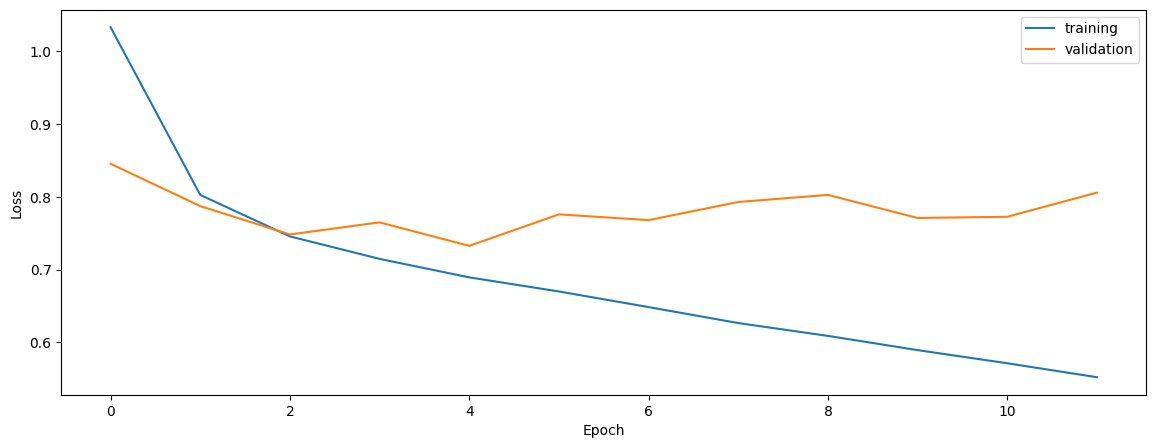

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


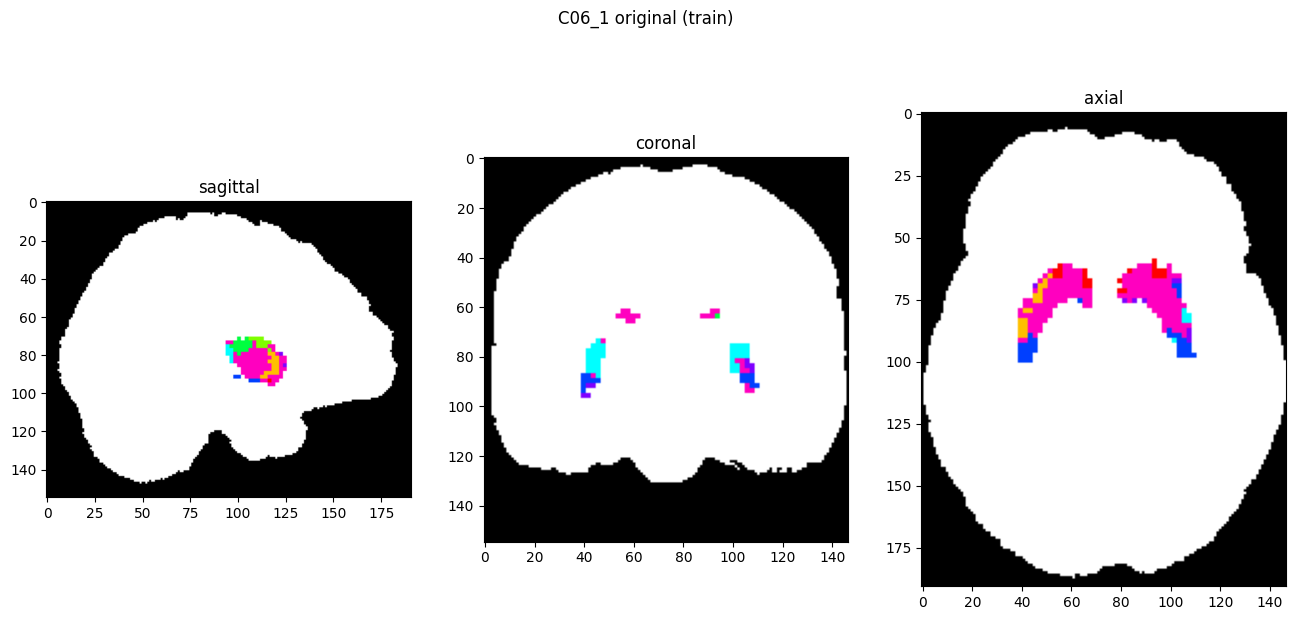

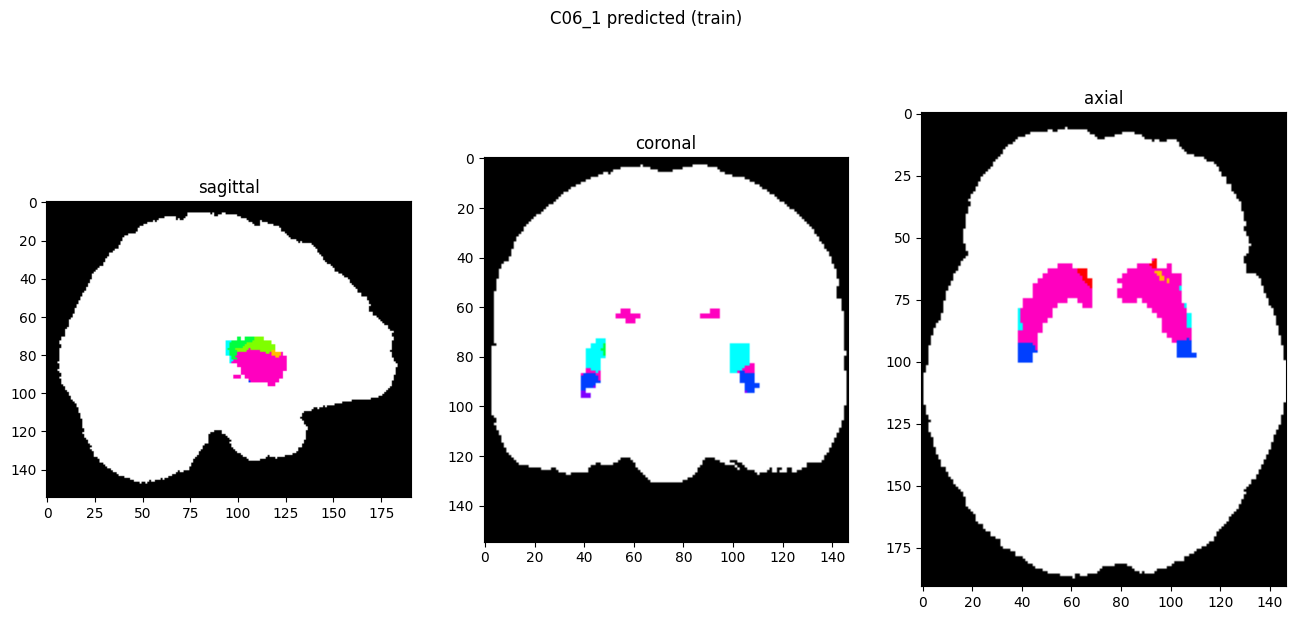

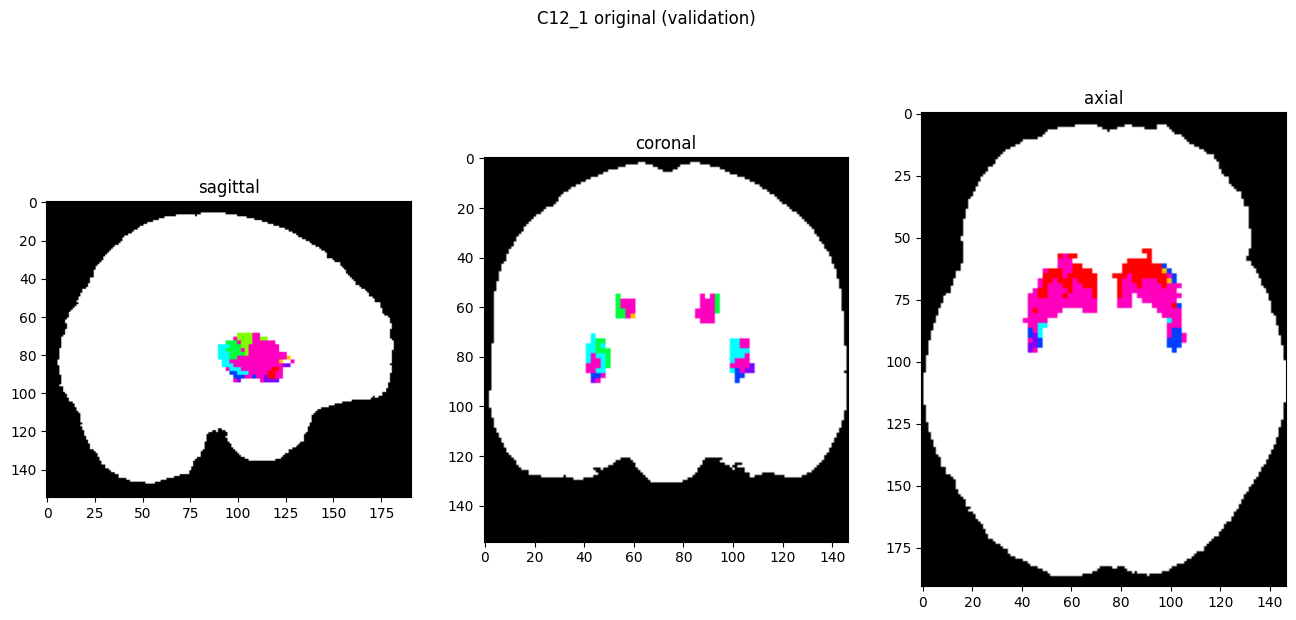

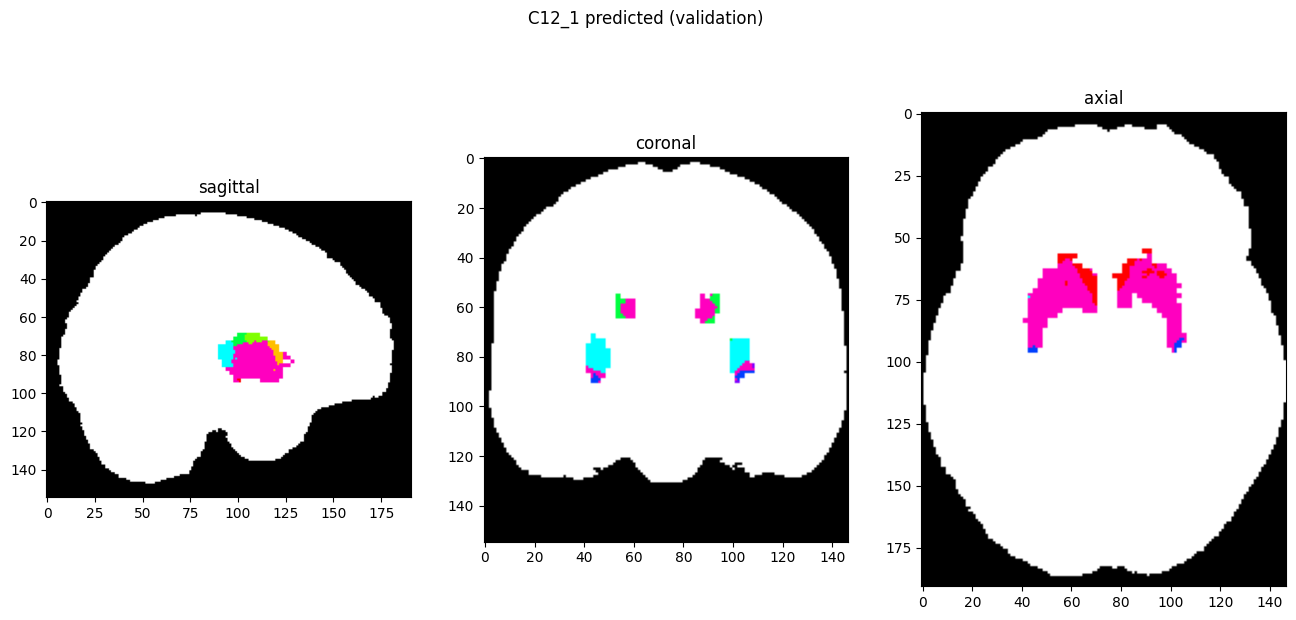

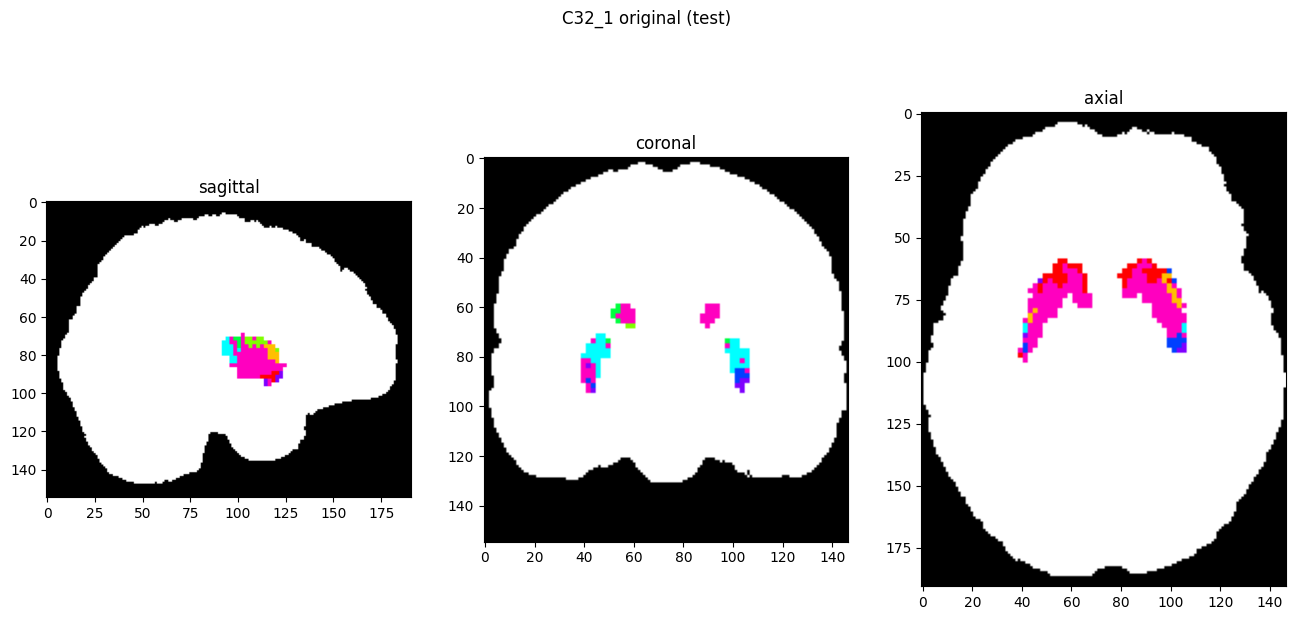

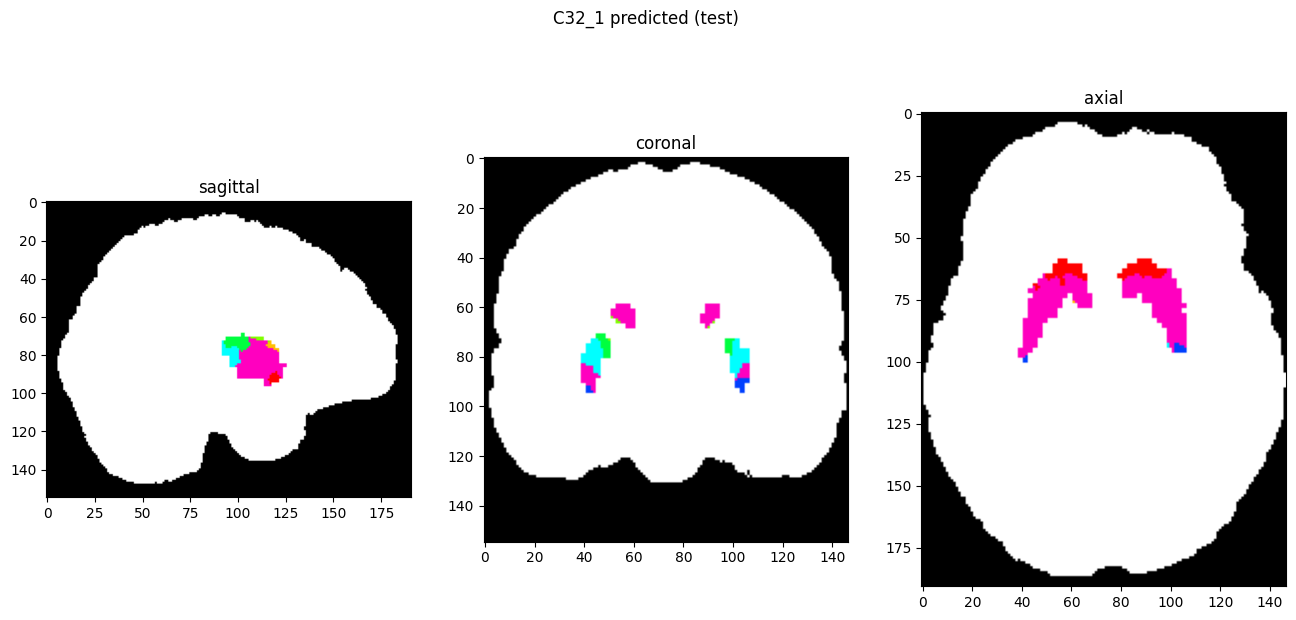

In [10]:
showResults(model, gen, threshold=0)